In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
search_result = lk.search_lightcurve('TIC 99869022', author='SPOC')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 41,2021,SPOC,120,99869022,0.0
1,TESS Sector 48,2022,SPOC,120,99869022,0.0


In [3]:
search_result[0]

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 41,2021,SPOC,120,99869022,0.0


In [4]:
#for column in search_result.table.columns:
#  print(column)

In [5]:
lc = search_result.download_all()
lc

LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 99869022" SECTOR=41 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 99869022" SECTOR=48 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

In [6]:
lc[0].columns

<TableColumns names=('time','flux','flux_err','timecorr','cadenceno','centroid_col','centroid_row','sap_flux','sap_flux_err','sap_bkg','sap_bkg_err','pdcsap_flux','pdcsap_flux_err','quality','psf_centr1','psf_centr1_err','psf_centr2','psf_centr2_err','mom_centr1','mom_centr1_err','mom_centr2','mom_centr2_err','pos_corr1','pos_corr2')>

In [7]:
type(lc[0].timecorr)

astropy.units.quantity.Quantity

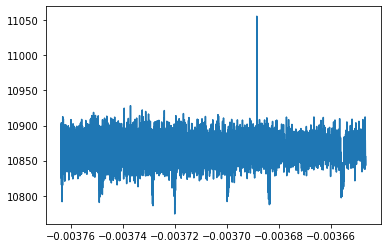

In [8]:
plt.plot(lc[0].timecorr, lc[0].flux)

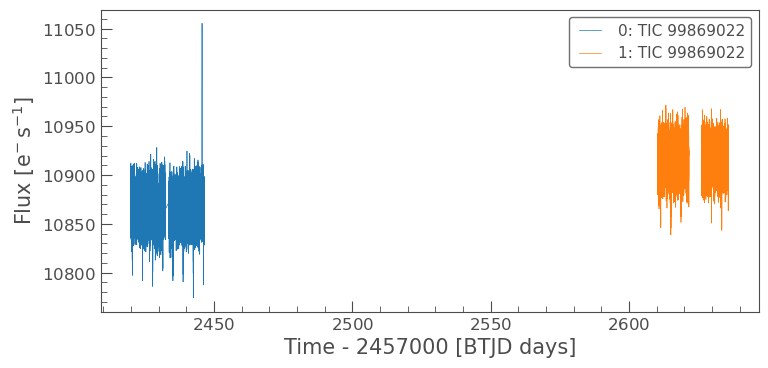

In [9]:
lc.plot();

In [10]:
lc_normalized = lc.stitch(lambda x: x.remove_nans().remove_outliers().normalize())

In [11]:
#k=0
#for i in lc:
#    lc[k] = i.remove_nans()
#    k+=1

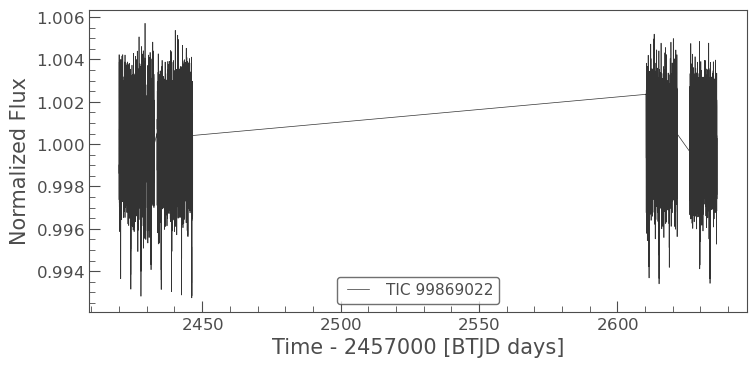

In [11]:
lc_normalized.plot();

In [27]:
lc_normalized_folded = lc_normalized.fold(period = 3.6714496, epoch_time = 2459442.56707-2457000)

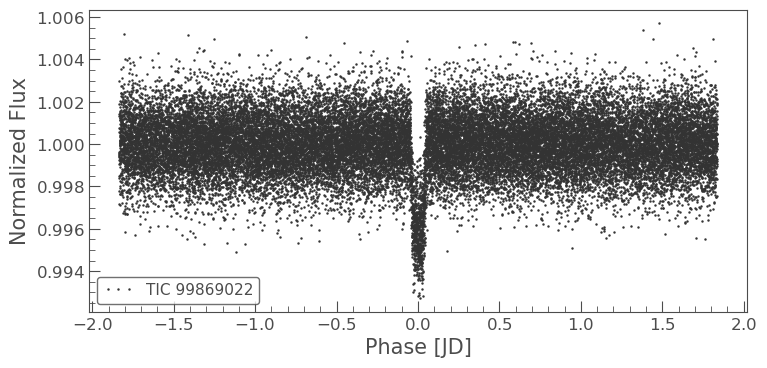

In [34]:
lc_normalized_folded.plot(marker='.', markersize=1.5, ls='');
plt.savefig('toi_1199_tess_data_folded.png',dpi=400,bbox_inches='tight')
#plt.xlim(-0.2,0.2)

In [29]:
lc_normalized_folded.time

<TimeDelta object: scale='None' format='jd' value=[-1.83556749 -1.83528224 -1.83525216 ...  1.83558334  1.83564857
  1.83568242]>

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

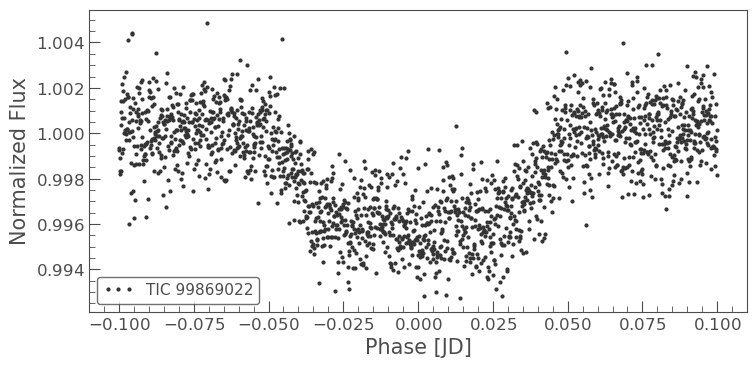

In [30]:
lc_normalized_folded.truncate(before = -0.1, after= 0.1, column = 'time').plot(marker='o', ls='')

In [17]:
lc2 = lc_normalized_folded.truncate(before = -0.1, after= 0.1, column = 'time')

In [18]:
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

In [19]:
bls_period = 4.63133263
bls_t0 = 2458712.34791
bls_depth = 0.00414383

phase_lc = np.linspace(-0.1, 0.1, 100)

texp = 120/(60.0 * 60.0 * 24.0) # la exposicion es de 120 segundos, pasamos a dias

x = lc2.time_original
y = lc2.flux
yerr = lc2.flux_err

In [59]:
def build_model(start=None):
    with pm.Model() as model:
        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=1.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)
        # Stellar parameters from exofop
        M_star = 0.99, 0.127451
        R_star = 1.53552, 0.0772462
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])
        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)
        period = pm.Deterministic("period", tt.exp(log_period))
        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)
    
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)
        
        # Transit jitter
        log_sigma_lc = pm.Normal("log_sigma_lc", mu=np.log(np.std(y)).value, sd=10)
        #log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10)
        #log_sigma_gp = pm.Normal("log_sigma_gp", mu=np.log(np.std(y)), sd=10)
        
        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )
        
        # Compute the model light curve
        light_curves = (star.get_light_curve(orbit=orbit, r=r_pl, t=x.value, texp=texp)*1e3)
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y - light_curve
        
        err = tt.sqrt(yerr.value**2 + tt.exp(2 * log_sigma_lc))
        pm.Normal("obs", mu=light_curve, sd=err, observed=y)

        pm.Deterministic(
            "lc_pred",
            1e3
            * star.get_light_curve(orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp)[..., 0],)
        
        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(start=start, vars=[log_sigma_lc])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc])
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves"],
                pmx.eval_in_model([light_curves], map_soln),
            )
        )

    return model, map_soln, extras

In [60]:
model0, map_soln0, extras0 = build_model()

['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [log_sigma_lc]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: 13476.42869359759 -> 13516.531331089025


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [log_depth]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: 13516.531331089025 -> 13516.531331089025


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: 13516.531331089025 -> 13516.531331089025


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [t0, log_period]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: 13516.531331089025 -> 13516.531331089025


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/ho

optimizing logp for variables: [u_star]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: 13516.531331089025 -> 13516.531331089025


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [log_depth]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: 13516.531331089025 -> 13516.531331089025


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: 13516.531331089025 -> 13516.531331089025


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ecs]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: 13516.531331089025 -> 13517.107137471981


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [mean]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: 13517.107137471981 -> 13727.618637118607


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [log_sigma_lc]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: 13727.618637118607 -> 13744.53131940651


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: 13744.53131940651 -> 13789.829054784048


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


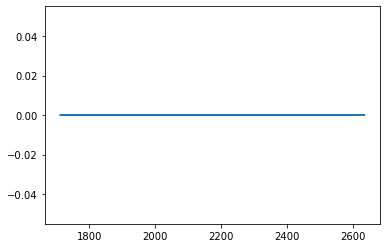

In [121]:

#plt.plot(x.value, y-map_soln0['log_sigma_lc'], "k")
mod = extras0["light_curves"][:, 0]
plt.plot(x.value, mod)
#ax.legend(fontsize=10, loc=3)
#ax.set_ylabel("de-trended flux [ppt]")